In [1]:
# PART 1: IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
)
import os
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# PART 2: MOUNT GOOGLE DRIVE & DEFINE PATHS

drive.mount('/content/drive')

results_path = '/content/drive/MyDrive/AIML/Results'
final_path = results_path + '/content/drive/MyDrive/final_preprocessed_dataset12.csv'
cluster_vis_path = results_path + 'clustering_visualizations/'

os.makedirs(cluster_vis_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# PART 3: LOAD FINAL PREPROCESSED DATASET

df = pd.read_csv('/content/drive/MyDrive/AIML/final_preprocessed_dataset (1).csv')
print("Loaded preprocessed dataset:", df.shape)

# Separate features and labels
X = df.drop(columns=["Target"])
y = df["Target"]

# Handle NaN values in y by removing corresponding rows from X and y
nan_mask = y.isna()
X = X[~nan_mask]
y = y[~nan_mask]
df = df[~nan_mask] # Update df to keep X and y consistent

# Map numeric target to readable names
label_map = {0: "Dropout", 1: "Enrolled", 2: "Graduate"}
y_named = y.map(label_map) if y.nunique() <= 3 else y

Loaded preprocessed dataset: (6295, 21)


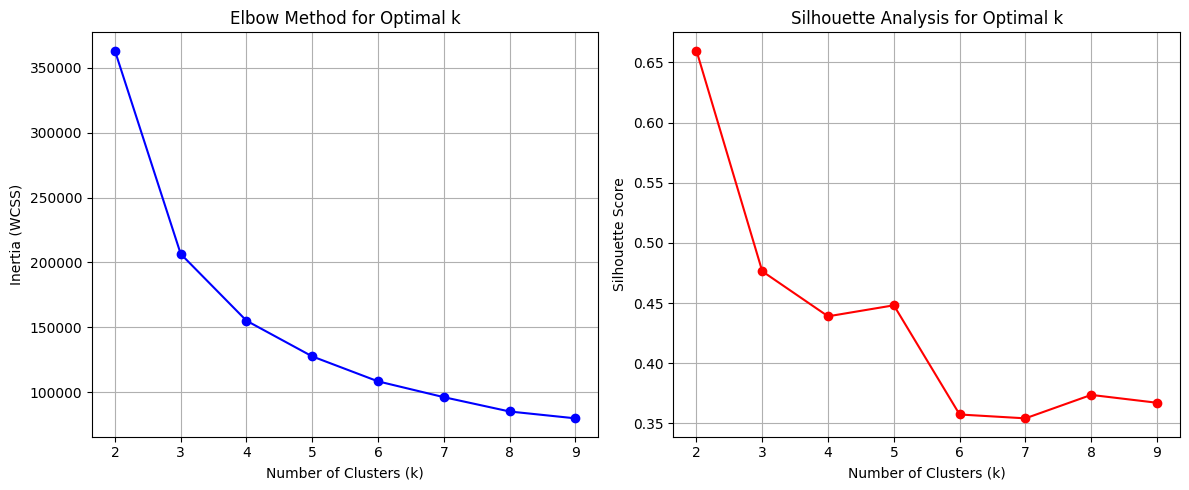

In [5]:
# PARAMETER TUNING - FINDING OPTIMAL K

# Define the range of k values to test
k_range = range(2, 10)
inertia = []
silhouette_scores = []

# Loop through the range of k values
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X)
    inertia.append(kmeans_model.inertia_)

    # Calculate Silhouette Score (only if k > 1)
    if k > 1:
        score = silhouette_score(X, kmeans_model.labels_)
        silhouette_scores.append(score)

# Visualization 1: Elbow Method (Inertia Plot)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)

# Visualization 2: Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.savefig(cluster_vis_path + "kmeans_parameter_tuning.png")
plt.show()

# Variety 1: k=3 (based on ground truth)
# Variety 2: k=4 (based on potential optimal k from tuning analysis)

In [6]:
# PART 4: TRAIN AND COMPARE TWO MODEL VARIETIES

def evaluate_kmeans(X, y, k, label_map):
    """Trains K-Means for a given k and evaluates using both unsupervised (Silhouette)
    and supervised (Accuracy, F1) metrics against ground truth (y)."""

    # 1. Train Model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    # 2. Unsupervised Metric (Silhouette Score)
    silhouette = silhouette_score(X, clusters)

    # 3. Supervised Metrics (Accuracy & F1)
    # Simple Purity/Best Mapping calculation
    contingency = pd.crosstab(y, clusters)
    best_mapping = [contingency[col].idxmax() for col in contingency.columns]
    mapping_dict = {i: best_mapping[i] for i in range(k)}
    mapped_clusters = np.array([mapping_dict[c] for c in clusters])

    best_acc = accuracy_score(y, mapped_clusters)
    f1 = f1_score(y, mapped_clusters, average='weighted')

    return silhouette, best_acc, f1, clusters, mapped_clusters


# Model A: K-Means with k=3 (True Classes)
k_model_A = 3
sil_A, acc_A, f1_A, clusters_A, pred_labels_A = evaluate_kmeans(X, y, k_model_A, label_map)

# Model B: K-Means with k=4 (Tuned Value/Variety)
k_model_B = 4
sil_B, acc_B, f1_B, clusters_B, pred_labels_B = evaluate_kmeans(X, y, k_model_B, label_map)

# Comparison Summary
print("--- Model Comparison ---")
comparison_data = {
    'Model': [f'K-Means (k={k_model_A})', f'K-Means (k={k_model_B})'],
    'Optimal k Source': ['Ground Truth', 'Tuning Variety'],
    'Silhouette Score': [f'{sil_A:.3f}', f'{sil_B:.3f}'],
    'Mapped Accuracy': [f'{acc_A:.2f}', f'{acc_B:.2f}'],
    'Weighted F1 Score': [f'{f1_A:.2f}', f'{f1_B:.2f}']
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_markdown(index=False))

optimal_k = k_model_A
df["Cluster"] = clusters_A
pred_labels = pred_labels_A

--- Model Comparison ---
| Model         | Optimal k Source   |   Silhouette Score |   Mapped Accuracy |   Weighted F1 Score |
|:--------------|:-------------------|-------------------:|------------------:|--------------------:|
| K-Means (k=3) | Ground Truth       |              0.476 |              0.39 |                0.33 |
| K-Means (k=4) | Tuning Variety     |              0.439 |              0.41 |                0.39 |


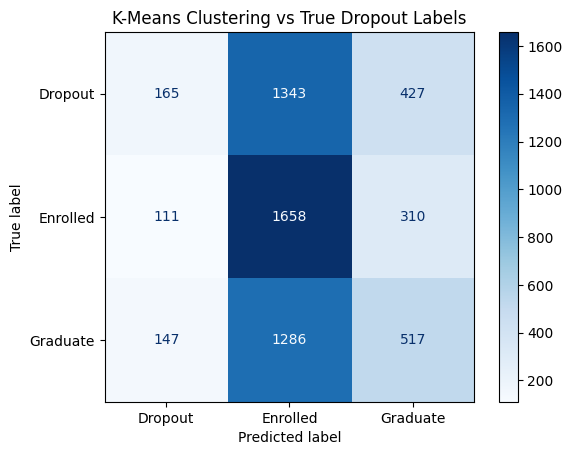

In [7]:
# PART 6: CONFUSION MATRIX VISUALIZATION

cm = confusion_matrix(y, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=list(label_map.values()))
disp.plot(cmap="Blues", values_format='d')
plt.title("K-Means Clustering vs True Dropout Labels")
plt.savefig(cluster_vis_path + "kmeans_confusion_matrix.png", bbox_inches='tight')
plt.show()

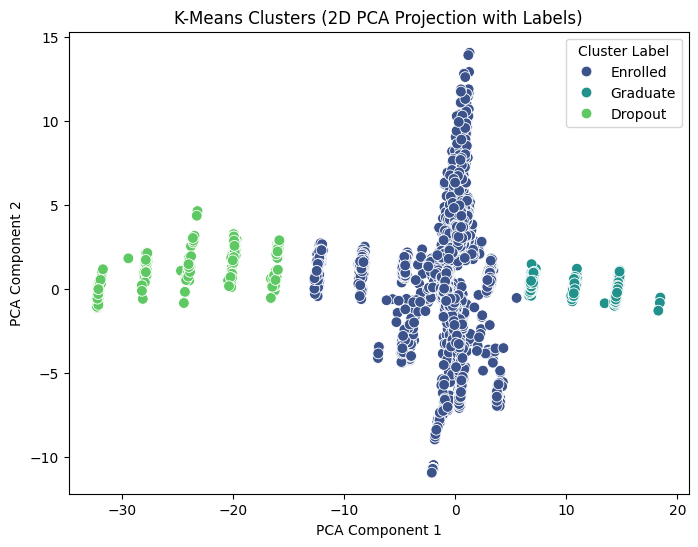

In [8]:
# PART 7: PCA VISUALIZATION WITH CLUSTER LABELS

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Assign cluster name labels based on majority vote
cluster_label_map = {}
for cluster_id in sorted(df["Cluster"].unique()):
    mask = df["Cluster"] == cluster_id
    majority_class = y_named[mask].mode()[0]
    cluster_label_map[cluster_id] = majority_class

df["Cluster_Name"] = df["Cluster"].map(cluster_label_map)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_result[:,0],
    y=pca_result[:,1],
    hue=df["Cluster_Name"],
    palette="viridis",
    s=60
)
plt.title("K-Means Clusters (2D PCA Projection with Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster Label")
plt.savefig(cluster_vis_path + "kmeans_clusters_pca_labeled.png", bbox_inches='tight')
plt.show()

In [14]:
# PART 8: SAVE CLUSTERED DATASET & SUMMARY

clustered_dataset_path = results_path + "kmeans_clustered_dataset.csv"
df.to_csv(clustered_dataset_path, index=False)
print("Clustered dataset saved to:", clustered_dataset_path)

# Cluster summary (average feature values per cluster)
cluster_summary = df.groupby("Cluster_Name").mean()
summary_path = results_path + "kmeans_cluster_summary.csv"
cluster_summary.to_csv(summary_path)
print("Cluster summary saved to:", summary_path)

# Display final results
print("\nK-Means clustering completed successfully!")
print(f"• Number of clusters: {optimal_k}")
print(f"• Silhouette Score: {sil_A:.3f}")
print(f"• Accuracy (best mapping): {acc_A:.2f}")
print(f"• F1 Score: {f1_A:.2f}")
print(f"• Clustered dataset: {clustered_dataset_path}")
print(f"• PCA plot: {cluster_vis_path}kmeans_clusters_pca_labeled.png")

Clustered dataset saved to: /content/drive/MyDrive/AIML/Resultskmeans_clustered_dataset.csv
Cluster summary saved to: /content/drive/MyDrive/AIML/Resultskmeans_cluster_summary.csv

K-Means clustering completed successfully!
• Number of clusters: 3
• Silhouette Score: 0.476
• Accuracy (best mapping): 0.39
• F1 Score: 0.33
• Clustered dataset: /content/drive/MyDrive/AIML/Resultskmeans_clustered_dataset.csv
• PCA plot: /content/drive/MyDrive/AIML/Resultsclustering_visualizations/kmeans_clusters_pca_labeled.png
